In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

import os
path = "C:/Users/aruni/Desktop/McGill/MGSC 662/Assignments/Decision Analytics Project Submission/"
os.chdir(path)

import warnings
warnings.filterwarnings('ignore')

# Model Summary
$n$ is the number of neighborhoods <br>
$N$ is set of neighborhood numbers, with $N=\{1,2,...,n\}$ <br>
$V$ is set of nodes; including the neighborhoods and the garbage disposal center, with $V=\{0\}\cup N$ <br>
$A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$ <br>
$dist_{ij}$ is the distance of arc $(i,j)\in A$ <br>
$Q$ is each garbage truck's capacity <br>
$q_i$ is the amount of garbage to be collected from neighborhood $i\in N$ <br>
$t_i$ is the time taken for the truck to collect garbage from neighborhood $i\in N$ <br>
$ \text{time_per_km}$ is the time taken (in minutes) by the truck to travel 1 km <br>
$ \text{daily_min_limit}$ is the maximum amount of time (in minutes) that each truck can travel in 1 day <br>


The problem can thus be formulated as the following: <br>

Objective:

 $$\begin{equation}
        \text{Minimize} \sum_{i,j\in\ A} dist_{ij} x_{ij}
    \end{equation} $$
    

Constraints:

 $$\begin{equation}
     \sum_{i\in\ V, i \neq j} x_{ij} = 1
    \end{equation} $$
    

 $$\begin{equation}
     \sum_{j\in\ V, j \neq i} x_{ij} = 1
    \end{equation} $$
    

 $$\begin{equation}
     \text{If }  x_{ij} = 1 \text{ then } u_{1i} + q_{i} = u_{1j} \text{; where, }i,j\in\ A \text{ and } j \neq 0, i \neq 0
    \end{equation} $$

 $$\begin{equation}
     \ u_{1i} >= q_{i} \text{;  for all } i\in\ A
    \end{equation} $$

 $$\begin{equation}
     \ u_{1i} <= Q \text{;  for all } i\in\ A
    \end{equation} $$

 $$\begin{equation}
     \text{If }  x_{ij} = 1 \text{  then } u_{2i} + t_{j}  + (dist_{i,j}* \text{time_perkm}) = u_{2j} \text{; where, }i,j\in\ A \text{ and } j \neq 0, i \neq 0
    \end{equation} $$

 $$\begin{equation}
     \text{If }  x_{ij} = 1 \text{  then }(dist_{0,j}* \text{time_perkm}) = u_{3j} \text{; where, }i,j\in\ A \text{ and } j \neq 0, i = 0
    \end{equation} $$

 $$\begin{equation}
     \text{If }  x_{ij} = 1 \text{  then }(dist_{0,j}* \text{time_perkm}) = u_{4j} \text{; where, }i,j\in\ A \text{ and } j = 0, i \neq 0
    \end{equation} $$

 $$\begin{equation}
     \ u_{2i} >= t_{i} \text{;  for all } i\in\ N
    \end{equation} $$

 $$\begin{equation}
     \ u_{2i} + u_{3i} + u_{4i} <= \text{daily_min_limit} \text{;  for all } i\in\ N
    \end{equation} $$

# Data Loading and Preparation
Loading the distance matrix obtained from Google API results

In [2]:
dist = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Distances")

locations = list(dist["Locations"])
dist.set_index("Locations", inplace=True)
dist.head(5)

,Montreal Junk and Garbage Removal,Ahuntsic-Cartierville,Anjou,Cote-des-Neiges–Notre-Dame-de-Grace,Lachine,LaSalle,Le Plateau-Mont-Royal,Le Sud-Ouest,L'Ile-Bizard–Sainte-Genevieve,Mercier–Hochelaga-Maisonneuve,...,Pierrefonds-Roxboro,Riviere-des-Prairies–Pointe-aux-Trembles,Rosemont–La Petite-Patrie,Saint-Laurent,Saint-Leonard,Verdun,Ville-Marie,Villeray–Saint-Michel–Parc-Extension,West Island,Westmount
Locations,,,,,,,,,,,,,,,,,,,,,
Montreal Junk and Garbage Removal,0.0,6.8,20.3,14.5,12.2,16.7,13.9,14.0,16.5,20.3,...,15.4,26.9,15.3,4.1,16.8,16.1,19.2,11.1,14.0,12.3
Ahuntsic-Cartierville,6.9,0.0,13.4,15.6,16.6,21.1,7.3,14.6,21.2,13.2,...,20.4,14.9,9.0,10.5,10.3,16.7,11.5,4.5,14.2,12.9
Anjou,20.4,13.9,0.0,24.3,25.7,30.4,14.1,23.4,37.7,8.7,...,36.0,5.6,11.5,23.8,4.8,24.7,16.5,12.2,23.4,22.1
Cote-des-Neiges–Notre-Dame-de-Grace,14.9,14.8,24.7,0.0,5.9,4.6,12.8,4.8,25.9,17.9,...,23.3,30.0,14.8,13.8,21.3,7.5,9.9,15.6,1.0,4.4
Lachine,12.4,18.7,30.4,6.3,0.0,6.7,19.0,10.8,21.1,24.2,...,18.5,35.7,21.1,9.0,26.9,11.5,16.2,21.2,7.6,11.7


Loading the number of households and coordinates for each borough:

In [3]:
location_details = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Location_Details")
location_details.set_index("Locations", inplace=True)

Garbage produced in a borough is a function of the number of households in the borough: 

In [4]:
location_details['Daily Garbage Produced (in lbs)'] = location_details['Number of Households']*2.7*20

Time taken for garbage collection per borough is computed as a function of the number of households in the borough: 

In [5]:
time_pickup = 1
location_details['Garbage Pickup Time (in mins)'] = location_details['Number of Households']*time_pickup

In [6]:
location_details.head(5)

,latitude,longitude,Number of Households,Daily Garbage Produced (in lbs),Garbage Pickup Time (in mins)
Locations,,,,,
Montreal Junk and Garbage Removal,45.513014,-73.727823,0,0.0,0
Ahuntsic-Cartierville,45.545296,-73.666566,76,4104.0,76
Anjou,45.615353,-73.564764,141,7614.0,141
Côte-des-Neiges–Notre-Dame-de-Grâce,45.459225,-73.638656,160,8640.0,160
Lachine,45.437915,-73.692492,65,3510.0,65


In [7]:
n = len(dist)-1  #number of neighborhoods
dist = np.array(dist)
N = [i for i in range(1, (n+1))]  #set of neighborhood numbers
V = [0] + N   #set of nodes (neighborhoods + disposal center)
A = [(i, j) for i in V for j in V if i != j]   #potential paths
Q = 28000   #truck capacity (in lbs)
time_perkm = 2  #time taken by truck to travel 1km
daily_min_limit = 7*60  #max daily time limit for each truck

q_temp=list(location_details["Daily Garbage Produced (in lbs)"])
q_temp.pop(0)
q = dict(zip(N,q_temp))   #garbage quantity collected from each neighborhood

t_temp=list(location_details["Garbage Pickup Time (in mins)"])
t_temp.pop(0)
t = dict(zip(N,t_temp))   #time taken for garbage pickup from each neighborhood

## Mapping the Neighbourhoods and the Waste Depot 

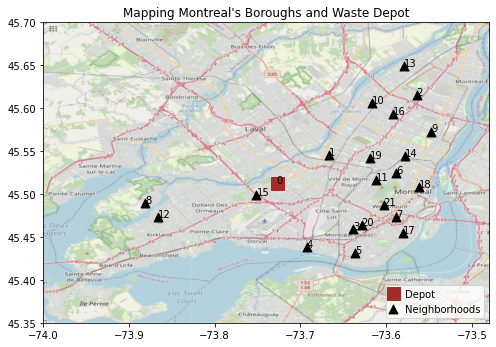

<Figure size 640x480 with 0 Axes>

In [8]:
df = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Location_Details")

BBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

BBox2 = (-74.00,-73.48,45.3500, 45.7000)

ruh_m = plt.imread('map_pic2.png')
fig, ax = plt.subplots(figsize = (8,7))

xc = df['longitude']
yc = df['latitude']

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))
     
#ax.scatter(df.longitude, df.latitude, zorder=1, c='b', s=10)
ax.plot(xc[0], yc[0], c='brown', marker='s', ms=13, label='Depot') #Waste Depot Site
ax.scatter(xc[1:], yc[1:], c='black', marker='^', s = 80, label = 'Neighborhoods') #Neighborhoods

ax.set_title('Mapping Montreal\'s Boroughs and Waste Depot')
ax.set_xlim(BBox2[0],BBox2[1])
ax.set_ylim(BBox2[2],BBox2[3])
ax.imshow(ruh_m, zorder=0, extent = BBox2, aspect= 'equal')

#setting up the legend
legend = ax.legend(loc = "lower right", handlelength=0.7)

# Model Building & Optimization in Gurobi

In [9]:
import gurobipy as gb
from gurobipy import *

model = gb.Model('Garbage Collection VRP')

Restricted license - for non-production use only - expires 2022-01-13


## Decision Variables

- x: Binary decision variable to indicate whether an arc (from i to j) is active [1] or not [0]:
- u1: Continuous decision variable for the garbage volume collected from a particular neighborhood
- u2: Continuous decision variable for the time taken in garbage collection and moving across across neighborhoods
- u3: Decision variable for the time taken in moving from disposal center to first neighborhood 
- u4: Decision variable for the time taken in moving from the last neighborhood to disposal center:

In [10]:
x = model.addVars(A, vtype=GRB.BINARY, name=['x_'+str(i)+'_'+str(j) for i in V for j in V if i != j])

u1 = model.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Quantity_"+str(i) for i in N])

u2 = model.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U2_"+str(i) for i in N])

u3 = model.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U3_"+str(i) for i in N])
 
u4 = model.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U4_"+str(i) for i in N])

## Objective

In [11]:
model.setObjective(sum(x[i, j]*dist[i, j] for i, j in A), GRB.MINIMIZE)   # Minimize Distance  

## Constraints

Truck must enter each neighborhood exactly once:

In [12]:
for j in N:
    model.addConstr(sum(x[i,j] for i in V if i!=j) == 1)

Truck must exit each neighborhood exactly once:

In [13]:
for i in N:
    model.addConstr(sum(x[i,j] for j in V if j!=i) == 1)

If the truck goes from i to j points then the truck's current garbage volume is given by the garbage collected until point i + garbage produced at j'th neighborhood:

In [14]:
for i, j in A:
    if i != 0 and j != 0:
        model.addConstr((x[i, j] == 1) >> (u1[i]+q[j] == u1[j]))

- Truck's garbage volume at any time is greater than or equal to each neighborhood's garbage volume
- Truck's current garbage volume cannot exceed it's maximum capacity

In [15]:
for i in N:
    model.addConstr(u1[i] >= q[i])   
    model.addConstr(u1[i] <= Q)  

If the truck goes from i to j points then the truck's current time spent is given by the time spent until point i + garbage pickup time at j'th neighborhood + time taken to travel from i to j:

In [16]:
for i, j in A:
    if i != 0 and j != 0:
        model.addConstr((x[i, j] == 1) >> (u2[i]+t[j]+(dist[i,j]*time_perkm) == u2[j]))

Time taken from the disposal center to the first location is stored in dummy variable u3:

In [17]:
for i, j in A:
    if i==0 and j!=0:
        model.addConstr((x[i, j] == 1) >> (dist[0,j]*time_perkm == u3[j]))
        

Time taken from the last location to the disposal center is stored in variable u4:

In [18]:
for i, j in A:
    if j==0 and i!=0:
        model.addConstr((x[i, j] == 1) >> (dist[0,i]*time_perkm == u4[i]))

- Truck's current time spent is greater than or equal to each neighborhood's garbage pickup time
- Truck's total time spent cannot exceed it's daily time limit, i.e., 7 hours

In [19]:
for i in N:
    model.addConstr(u2[i] >= t[i])  
    model.addConstr(u2[i]+u3[i]+u4[i] <= daily_min_limit)   

## Model Optimization

In [20]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 126 rows, 546 columns and 1008 nonzeros
Model fingerprint: 0xa32dc398
Model has 882 general constraints
Variable types: 84 continuous, 462 integer (462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Presolve added 1015 rows and 340 columns
Presolve time: 0.10s
Presolved: 1141 rows, 886 columns, 7004 nonzeros
Presolved model has 353 SOS constraint(s)
Variable types: 493 continuous, 393 integer (393 binary)
Found heuristic solution: objective 627.4000000

Root relaxation: objective 1.127309e+02, 153 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  112.73093    0  109  627.40000  

  MIR: 51
  StrongCG: 11
  Flow cover: 44
  GUB cover: 54
  Inf proof: 5
  Zero half: 36
  RLT: 10
  Relax-and-lift: 52

Explored 135952 nodes (4925743 simplex iterations) in 185.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 308.7 308.9 310.4 ... 323.7

Optimal solution found (tolerance 1.00e-04)
Best objective 3.087000000000e+02, best bound 3.087000000000e+02, gap 0.0000%


## Model Results

In [21]:
print("Minimized distance:", round(model.objVal,2))

print("\nDVs:")

for v in model.getVars():
    if round(v.x,0) == 1:
        print(v.varName,":",v.x)

Minimized distance: 308.7

DVs:
x_0_2 : 1.0
x_0_3 : 0.999999999999954
x_0_9 : 1.0
x_0_14 : 1.0
x_0_15 : 1.0
x_0_19 : 1.0
x_0_20 : 1.0
x_0_21 : 1.0
x_1_0 : 1.0
x_2_13 : 1.0
x_3_5 : 0.999999999999954
x_4_0 : 1.0
x_5_4 : 1.0
x_6_1 : 1.0000000000000056
x_7_17 : 0.999999999999954
x_8_12 : 1.0
x_9_11 : 1.0
x_10_0 : 1.0
x_11_0 : 1.0
x_12_0 : 1.0
x_13_16 : 1.0
x_14_6 : 1.0
x_15_8 : 1.0
x_16_0 : 1.0
x_17_0 : 1.0
x_18_0 : 1.0
x_19_10 : 1.0
x_20_7 : 1.0
x_21_18 : 1.0


In [22]:
print("Minimized distance:", round(model.objVal,2))
print("\nTruck Paths:")
l1=[]
l2=[]

for v in model.getVars():
    if round(v.x,0) == 1:
        l1.append(int(v.varName.split('_')[1]))
        l2.append(int(v.varName.split('_')[2]))

df = pd.DataFrame(list(zip(l1, l2)), columns =['Point1', 'Point2'])

master_list = []

for i in range((list(df["Point1"]).count(0))):
    seq_l=[0]
    t = df["Point2"][i]
    
    j=0
    while(j<len(df)):
        seq_l.append(t) if t not in seq_l else seq_l
        
        if t==df["Point1"][j]:
            t = df["Point2"][j]
            j = 0
            if t==0:
                break
        else:
            j = j+1
    
    seq_l.append(0)
    master_list.append(seq_l)
    print("\nTruck",i+1,"Path: ", end='')
    for k in range(len(seq_l)):
        if k==len(seq_l)-1:
            print(seq_l[k], end='')
        else:
            print(seq_l[k],"-> ", end='')

Minimized distance: 308.7

Truck Paths:

Truck 1 Path: 0 -> 2 -> 13 -> 16 -> 0
Truck 2 Path: 0 -> 3 -> 5 -> 4 -> 0
Truck 3 Path: 0 -> 9 -> 11 -> 0
Truck 4 Path: 0 -> 14 -> 6 -> 1 -> 0
Truck 5 Path: 0 -> 15 -> 8 -> 12 -> 0
Truck 6 Path: 0 -> 19 -> 10 -> 0
Truck 7 Path: 0 -> 20 -> 7 -> 17 -> 0
Truck 8 Path: 0 -> 21 -> 18 -> 0

## Mapping the optimal paths:

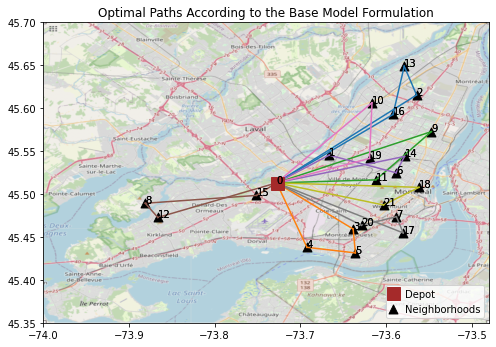

<Figure size 640x480 with 0 Axes>

In [23]:
df = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Location_Details")

BBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

BBox2 = (-74.00,-73.48,45.3500, 45.7000)

ruh_m = plt.imread('map_pic2.png')
fig, ax = plt.subplots(figsize = (8,7))

xc = df['longitude']
yc = df['latitude']

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))
     
#ax.scatter(df.longitude, df.latitude, zorder=1, c='b', s=10)
ax.plot(xc[0], yc[0], c='brown', marker='s', ms=13, label='Depot') #Waste Depot Site
ax.scatter(xc[1:], yc[1:], c='black', marker='^', s = 80, label = 'Neighborhoods') #Neighborhoods

active_arcs = [a for a in A if x[a].x > 0.99]


c_list  = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive"]

for i in range(len(master_list)):
    for j in range(len(master_list[i])-1): 
        a = master_list[i][j]
        b =  master_list[i][j+1]
        ax.plot([xc[a], xc[b]], [yc[a], yc[b]], c=c_list[i], zorder=1)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))


ax.set_title('Optimal Paths According to the Base Model Formulation')
ax.set_xlim(BBox2[0],BBox2[1])
ax.set_ylim(BBox2[2],BBox2[3])
ax.imshow(ruh_m, zorder=0, extent = BBox2, aspect= 'equal')

#setting up the legend
legend = ax.legend(loc = "lower right", handlelength=0.7)

# Model Extension 1 - Varying Truck Capacity
### Reduced truck capacity from 28000 lbs to 18000 lbs

Minimized distance: 351.7

Truck Paths:

Truck 1 Path: 0 -> 1 -> 6 -> 0
Truck 2 Path: 0 -> 5 -> 3 -> 0
Truck 3 Path: 0 -> 7 -> 20 -> 0
Truck 4 Path: 0 -> 13 -> 9 -> 14 -> 0
Truck 5 Path: 0 -> 15 -> 8 -> 12 -> 0
Truck 6 Path: 0 -> 16 -> 2 -> 0
Truck 7 Path: 0 -> 18 -> 17 -> 4 -> 0
Truck 8 Path: 0 -> 19 -> 10 -> 0
Truck 9 Path: 0 -> 21 -> 11 -> 0

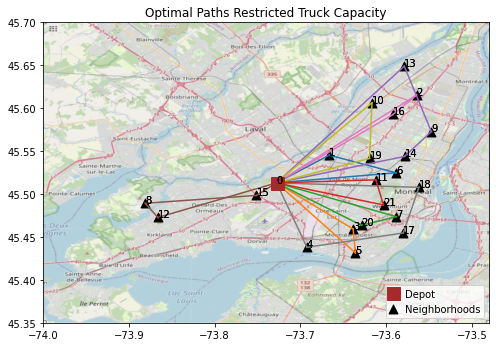

<Figure size 640x480 with 0 Axes>

In [24]:
# Setting Variables
n = len(dist)-1
dist = np.array(dist)
N = [i for i in range(1, (n+1))]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
time_perkm = 2 
daily_min_limit = 7*60
q_temp=list(location_details["Daily Garbage Produced (in lbs)"])
q_temp.pop(0)
q = dict(zip(N,q_temp)) 
t_temp=list(location_details["Garbage Pickup Time (in mins)"])
t_temp.pop(0)
t = dict(zip(N,t_temp))

Q_ext = 18000   #decreased truck capacity (in lbs)

import gurobipy as gb
from gurobipy import *

model_ext = gb.Model('Garbage Collection VRP - Extension')

# Decision Variables
x = model_ext.addVars(A, vtype=GRB.BINARY, name=['x_'+str(i)+'_'+str(j) for i in V for j in V if i != j])
u1 = model_ext.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Quantity_"+str(i) for i in N])
u2 = model_ext.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U2_"+str(i) for i in N])
u3 = model_ext.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U3_"+str(i) for i in N])
u4 = model_ext.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U4_"+str(i) for i in N])

# Objective Function
model_ext.setObjective(sum(x[i, j]*dist[i, j] for i, j in A), GRB.MINIMIZE)

# Constraints
for j in N:
    model_ext.addConstr(sum(x[i,j] for i in V if i!=j) == 1)

for i in N:
    model_ext.addConstr(sum(x[i,j] for j in V if j!=i) == 1)

for i, j in A:
    if i != 0 and j != 0:
        model_ext.addConstr((x[i, j] == 1) >> (u1[i]+q[j] == u1[j]))

for i in N:
    model_ext.addConstr(u1[i] >= q[i])
    model_ext.addConstr(u1[i] <= Q_ext)

for i, j in A:
    if i != 0 and j != 0:
        model_ext.addConstr((x[i, j] == 1) >> (u2[i]+t[j]+(dist[i,j]*time_perkm) == u2[j]))

for i, j in A:
    if i==0 and j!=0:
        model_ext.addConstr((x[i, j] == 1) >> (dist[0,j]*time_perkm == u3[j]))
        
for i, j in A:
    if j==0 and i!=0:
        model_ext.addConstr((x[i, j] == 1) >> (dist[0,i]*time_perkm == u4[i]))
        
for i in N:
    model_ext.addConstr(u2[i] >= t[i])
    model_ext.addConstr(u2[i]+u3[i]+u4[i] <= daily_min_limit)
    
# Model Optimization

model_ext.Params.LogToConsole = 0
model_ext.optimize()

# Printing results
print("Minimized distance:", round(model_ext.objVal,2))

print("\nTruck Paths:")
l1=[]
l2=[]

for v in model_ext.getVars():
    if round(v.x,0) == 1:
        l1.append(int(v.varName.split('_')[1]))
        l2.append(int(v.varName.split('_')[2]))

df = pd.DataFrame(list(zip(l1, l2)), columns =['Point1', 'Point2'])

master_list = []

for i in range((list(df["Point1"]).count(0))):
    seq_l=[0]
    t = df["Point2"][i]
    
    j=0
    while(j<len(df)):
        seq_l.append(t) if t not in seq_l else seq_l
        
        if t==df["Point1"][j]:
            t = df["Point2"][j]
            j = 0
            if t==0:
                break
        else:
            j = j+1
    
    seq_l.append(0)
    master_list.append(seq_l)
    print("\nTruck",i+1,"Path: ", end='')
    for k in range(len(seq_l)):
        if k==len(seq_l)-1:
            print(seq_l[k], end='')
        else:
            print(seq_l[k],"-> ", end='')
            
# Model result image

df = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Location_Details")

BBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

BBox2 = (-74.00,-73.48,45.3500, 45.7000)

ruh_m = plt.imread('map_pic2.png')
fig, ax = plt.subplots(figsize = (8,7))

xc = df['longitude']
yc = df['latitude']

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))
     
#ax.scatter(df.longitude, df.latitude, zorder=1, c='b', s=10)
ax.plot(xc[0], yc[0], c='brown', marker='s', ms=13, label='Depot') #Waste Depot Site
ax.scatter(xc[1:], yc[1:], c='black', marker='^', s = 80, label = 'Neighborhoods') #Neighborhoods

active_arcs = [a for a in A if x[a].x > 0.99]


c_list  = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:red"]

for i in range(len(master_list)):
    for j in range(len(master_list[i])-1): 
        a = master_list[i][j]
        b =  master_list[i][j+1]
        ax.plot([xc[a], xc[b]], [yc[a], yc[b]], c=c_list[i], zorder=1)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))

ax.set_title('Optimal Paths Restricted Truck Capacity')
ax.set_xlim(BBox2[0],BBox2[1])
ax.set_ylim(BBox2[2],BBox2[3])
ax.imshow(ruh_m, zorder=0, extent = BBox2, aspect= 'equal')
legend = ax.legend(loc = "lower right", handlelength=0.7)

# Model Extension 2:

## Finding the optimal number of hours of operation 

In [25]:
num_hours = [8, 7, 6]

daily_min_limit = [60*x for x in num_hours]
daily_min_limit

[480, 420, 360]

In [26]:
# Setting Variables
n = len(dist)-1
dist = np.array(dist)
N = [i for i in range(1, (n+1))]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
time_perkm = 2 


q_temp=list(location_details["Daily Garbage Produced (in lbs)"])
q_temp.pop(0)
q = dict(zip(N,q_temp)) 
t_temp=list(location_details["Garbage Pickup Time (in mins)"])
t_temp.pop(0)
t = dict(zip(N,t_temp))

Q = 28000   #truck capacity (in lbs)

import gurobipy as gb
from gurobipy import *

model3 = gb.Model('Garbage Collection VRP - Extension')

### Decision Variables

In [27]:
x = model3.addVars(A, vtype=GRB.BINARY, name=['x_'+str(i)+'_'+str(j) for i in V for j in V if i != j])
u1 = model3.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Quantity_"+str(i) for i in N])
u2 = model3.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U2_"+str(i) for i in N])
u3 = model3.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U3_"+str(i) for i in N])
u4 = model3.addVars(N, vtype=GRB.CONTINUOUS, name=["Dummy_Time_U4_"+str(i) for i in N])
y = model3.addVars(len(daily_min_limit), vtype=GRB.BINARY, name=["Dummy_Hours_"+str(i) for i in num_hours])
z = model3.addVar(vtype=GRB.CONTINUOUS, name= "Minutes Limit")

### Objective and Constraints from the Base Model

In [28]:
model3.setObjective(sum(x[i, j]*dist[i, j] for i, j in A), GRB.MINIMIZE)

# Truck must enter and exit each neighborhood exactly once:
for j in N:
    model3.addConstr(sum(x[i,j] for i in V if i!=j) == 1)

for i in N:
    model3.addConstr(sum(x[i,j] for j in V if j!=i) == 1)

# If the truck goes from i to j neighborhood then the truck's current garbage volume is given by
# the garbage collected until i + garbage produced at j'th neighborhood:
for i, j in A:
    if i != 0 and j != 0:
        model3.addConstr((x[i, j] == 1) >> (u1[i]+q[j] == u1[j]))

for i in N:
    model3.addConstr(u1[i] >= q[i])  # Truck's garbage volume at any time is greater than or equal to each neighborhood's garbage volume 
    model3.addConstr(u1[i] <= Q)   # Truck's current garbage volume cannot exceed it's maximum capacity

# If the truck goes from i to j neighborhood then the truck's current time spent is given by
# the time spent until i + garbage pickup time at j'th neighborhood + time taken to travel from i to j:
for i, j in A:
    if i != 0 and j != 0:
        model3.addConstr((x[i, j] == 1) >> (u2[i]+t[j]+(dist[i,j]*time_perkm) == u2[j]))

#time taken the disposal center to the first location is stored in dummy variable u3
for i, j in A:
    if i==0 and j!=0:
        model3.addConstr((x[i, j] == 1) >> (dist[0,j]*time_perkm == u3[j]))
        
#time taken from the last location to the disposal center is stored in a variable u4
for i, j in A:
    if j==0 and i!=0:
        model3.addConstr((x[i, j] == 1) >> (dist[0,i]*time_perkm == u4[i]))

### Additional Constraints

In [29]:
model3.addConstr(sum(y[i] for i in range(len(daily_min_limit))) == 1, name = "Pick_1_Constraint")

model3.addConstr( z  - sum(y[i] * daily_min_limit[i] for i in range(len(daily_min_limit))) == 0 )

for i in N:
    model3.addConstr(u2[i] >= t[i])   # Truck's current time spent is greater than or equal to each neighborhood's garbage pickup time
    model3.addConstr(u2[i]+u3[i]+u4[i] - z <= 0)    

## Solution 

In [30]:
model3.Params.MIPGap = 0.135
model3.Params.TimeLimit = 300
model3.Params.LogToConsole = 0
model3.optimize()

Changed value of parameter MIPGap to 0.135
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [31]:
# Printing results
print("Minimized distance:", round(model3.objVal,2))

for v in model3.getVars():
    print(v.varName,":",v.x)

Minimized distance: 275.3
x_0_1 : 0.0
x_0_2 : 1.0
x_0_3 : 0.0
x_0_4 : 0.0
x_0_5 : 1.0
x_0_6 : 0.0
x_0_7 : 0.0
x_0_8 : 1.0
x_0_9 : 0.0
x_0_10 : 0.0
x_0_11 : 1.0
x_0_12 : 0.0
x_0_13 : 0.0
x_0_14 : 0.0
x_0_15 : 0.0
x_0_16 : 1.0
x_0_17 : 0.0
x_0_18 : 0.0
x_0_19 : 1.0
x_0_20 : 0.0
x_0_21 : 1.0
x_1_0 : 1.0
x_1_2 : -0.0
x_1_3 : -0.0
x_1_4 : -0.0
x_1_5 : -0.0
x_1_6 : -0.0
x_1_7 : -0.0
x_1_8 : -0.0
x_1_9 : -0.0
x_1_10 : -0.0
x_1_11 : 0.0
x_1_12 : -0.0
x_1_13 : -0.0
x_1_14 : -0.0
x_1_15 : -0.0
x_1_16 : -0.0
x_1_17 : -0.0
x_1_18 : -0.0
x_1_19 : -0.0
x_1_20 : -0.0
x_1_21 : -0.0
x_2_0 : 0.0
x_2_1 : -0.0
x_2_3 : -0.0
x_2_4 : -0.0
x_2_5 : -0.0
x_2_6 : -0.0
x_2_7 : 0.0
x_2_8 : -0.0
x_2_9 : -0.0
x_2_10 : -0.0
x_2_11 : -0.0
x_2_12 : -0.0
x_2_13 : 1.0
x_2_14 : 0.0
x_2_15 : -0.0
x_2_16 : -0.0
x_2_17 : -0.0
x_2_18 : -0.0
x_2_19 : -0.0
x_2_20 : -0.0
x_2_21 : -0.0
x_3_0 : 0.0
x_3_1 : -0.0
x_3_2 : -0.0
x_3_4 : -0.0
x_3_5 : -0.0
x_3_6 : -0.0
x_3_7 : -0.0
x_3_8 : 0.0
x_3_9 : -0.0
x_3_10 : -0.0
x_3_11 : -0.0
x_3

Minimized distance: 275.3

Truck Paths:

Truck 1 Path: 0 -> 2 -> 13 -> 10 -> 0
Truck 2 Path: 0 -> 5 -> 3 -> 20 -> 0
Truck 3 Path: 0 -> 8 -> 12 -> 4 -> 15 -> 0
Truck 4 Path: 0 -> 11 -> 18 -> 1 -> 0
Truck 5 Path: 0 -> 16 -> 9 -> 0
Truck 6 Path: 0 -> 19 -> 14 -> 6 -> 0
Truck 7 Path: 0 -> 21 -> 7 -> 17 -> 0

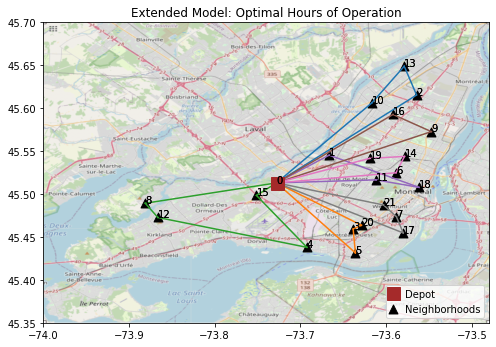

<Figure size 640x480 with 0 Axes>

In [32]:
# Printing results
print("Minimized distance:", round(model3.objVal,2))

print("\nTruck Paths:")
l1=[]
l2=[]

for v in model3.getVars():
    if "Hours" not in v.varName:
        if round(v.x,0) == 1:
            l1.append(int(v.varName.split('_')[1]))
            l2.append(int(v.varName.split('_')[2]))

df = pd.DataFrame(list(zip(l1, l2)), columns =['Point1', 'Point2'])

master_list = []

for i in range((list(df["Point1"]).count(0))):
    seq_l=[0]
    t = df["Point2"][i]
    
    j=0
    while(j<len(df)):
        seq_l.append(t) if t not in seq_l else seq_l
        
        if t==df["Point1"][j]:
            t = df["Point2"][j]
            j = 0
            if t==0:
                break
        else:
            j = j+1
    
    seq_l.append(0)
    master_list.append(seq_l)
    print("\nTruck",i+1,"Path: ", end='')
    for k in range(len(seq_l)):
        if k==len(seq_l)-1:
            print(seq_l[k], end='')
        else:
            print(seq_l[k],"-> ", end='')
            
# Model result image

df = pd.read_excel("Garbage Collection Optimization Datasets.xlsx", sheet_name="Location_Details")

BBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

BBox2 = (-74.00,-73.48,45.3500, 45.7000)

ruh_m = plt.imread('map_pic2.png')
fig, ax = plt.subplots(figsize = (8,7))

xc = df['longitude']
yc = df['latitude']

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))
     
#ax.scatter(df.longitude, df.latitude, zorder=1, c='b', s=10)
ax.plot(xc[0], yc[0], c='brown', marker='s', ms=13, label='Depot') #Waste Depot Site
ax.scatter(xc[1:], yc[1:], c='black', marker='^', s = 80, label = 'Neighborhoods') #Neighborhoods

active_arcs = [a for a in A if x[a].x > 0.99]


c_list  = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:red"]

for i in range(len(master_list)):
    for j in range(len(master_list[i])-1): 
        a = master_list[i][j]
        b =  master_list[i][j+1]
        ax.plot([xc[a], xc[b]], [yc[a], yc[b]], c=c_list[i], zorder=1)

for i, label in enumerate(V):
    ax.annotate(label, (xc[i], yc[i]))
    
    
    
ax.set_title('Extended Model: Optimal Hours of Operation')
ax.set_xlim(BBox2[0],BBox2[1])
ax.set_ylim(BBox2[2],BBox2[3])
ax.imshow(ruh_m, zorder=0, extent = BBox2, aspect= 'equal')
legend = ax.legend(loc = "lower right", handlelength=0.7)

# Code Appendix

In [33]:
print(pd.DataFrame(locations, columns=["Location Names"]))

                              Location Names
0          Montreal Junk and Garbage Removal
1                      Ahuntsic-Cartierville
2                                      Anjou
3        Cote-des-Neiges–Notre-Dame-de-Grace
4                                    Lachine
5                                    LaSalle
6                      Le Plateau-Mont-Royal
7                               Le Sud-Ouest
8              L'Ile-Bizard–Sainte-Genevieve
9              Mercier–Hochelaga-Maisonneuve
10                             Montreal-Nord
11                                 Outremont
12                       Pierrefonds-Roxboro
13  Riviere-des-Prairies–Pointe-aux-Trembles
14                 Rosemont–La Petite-Patrie
15                             Saint-Laurent
16                             Saint-Leonard
17                                    Verdun
18                               Ville-Marie
19      Villeray–Saint-Michel–Parc-Extension
20                               West Island
21        

In [34]:
print("Appendix - Behind the scenes calculations for base model")

print("\nDVs:")

for v in model.getVars():
    print(v.varName,":",v.x)

Appendix - Behind the scenes calculations for base model

DVs:
x_0_1 : 0.0
x_0_2 : 1.0
x_0_3 : 0.999999999999954
x_0_4 : 0.0
x_0_5 : 0.0
x_0_6 : 0.0
x_0_7 : 0.0
x_0_8 : 0.0
x_0_9 : 1.0
x_0_10 : 0.0
x_0_11 : 0.0
x_0_12 : 0.0
x_0_13 : 0.0
x_0_14 : 1.0
x_0_15 : 1.0
x_0_16 : 0.0
x_0_17 : 0.0
x_0_18 : 0.0
x_0_19 : 1.0
x_0_20 : 1.0
x_0_21 : 1.0
x_1_0 : 1.0
x_1_2 : -0.0
x_1_3 : -0.0
x_1_4 : -0.0
x_1_5 : -0.0
x_1_6 : -0.0
x_1_7 : -0.0
x_1_8 : -0.0
x_1_9 : -0.0
x_1_10 : 0.0
x_1_11 : -0.0
x_1_12 : -0.0
x_1_13 : -0.0
x_1_14 : -0.0
x_1_15 : -0.0
x_1_16 : -0.0
x_1_17 : -0.0
x_1_18 : 0.0
x_1_19 : 0.0
x_1_20 : -0.0
x_1_21 : -0.0
x_2_0 : 0.0
x_2_1 : -0.0
x_2_3 : -0.0
x_2_4 : -0.0
x_2_5 : -0.0
x_2_6 : 0.0
x_2_7 : -0.0
x_2_8 : -0.0
x_2_9 : 0.0
x_2_10 : 0.0
x_2_11 : 0.0
x_2_12 : -0.0
x_2_13 : 1.0
x_2_14 : -0.0
x_2_15 : -0.0
x_2_16 : 0.0
x_2_17 : -0.0
x_2_18 : -0.0
x_2_19 : -0.0
x_2_20 : -0.0
x_2_21 : -0.0
x_3_0 : 4.596323321948148e-14
x_3_1 : -0.0
x_3_2 : -0.0
x_3_4 : 0.0
x_3_5 : 0.999999999999954
x_3_6 

Dummy_Time_U3_16 : 0.0
Dummy_Time_U3_17 : 0.0
Dummy_Time_U3_18 : 0.0
Dummy_Time_U3_19 : 22.2
Dummy_Time_U3_20 : 28.0
Dummy_Time_U3_21 : 24.6
Dummy_Time_U4_1 : 13.6
Dummy_Time_U4_2 : 0.0
Dummy_Time_U4_3 : 1.3322676295501878e-12
Dummy_Time_U4_4 : 24.4
Dummy_Time_U4_5 : 0.0
Dummy_Time_U4_6 : -1.5276668818842154e-13
Dummy_Time_U4_7 : 1.2860823517257813e-12
Dummy_Time_U4_8 : 0.0
Dummy_Time_U4_9 : 0.0
Dummy_Time_U4_10 : 30.2
Dummy_Time_U4_11 : 23.0
Dummy_Time_U4_12 : 30.8
Dummy_Time_U4_13 : 0.0
Dummy_Time_U4_14 : 0.0
Dummy_Time_U4_15 : 0.0
Dummy_Time_U4_16 : 33.6
Dummy_Time_U4_17 : 32.2
Dummy_Time_U4_18 : 38.4
Dummy_Time_U4_19 : 0.0
Dummy_Time_U4_20 : 0.0
Dummy_Time_U4_21 : 0.0


In [ ]:
### Code used for web scraping the distances

'''
import bs4 as bs
from bs4 import BeautifulSoup
import requests
import time

import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys



#Chrome Driver 
chrome_options = Options()

#opens the website
driver = webdriver.Chrome(ChromeDriverManager().install()) #gets the new version of chrome 
driver.maximize_window()



#function(starting_point, ending_poitn)
url = "https://www.google.com/maps"
driver.get(url)




def nav_location(start_location, end_location): 
    url = "https://www.google.com/maps"
    driver.get(url)
      
    search_bar = driver.find_elements_by_xpath("""//*[@id="searchboxinput"]""")
    search_bar[0].click()
    
    search_bar[0].send_keys(end_location)
    
    search_button = driver.find_elements_by_xpath("""//*[@id="searchbox-searchbutton"]""")
    search_button[0].click()
    

    
    directions_button = driver.find_elements_by_xpath("""//*[@id="pane"]/div/div[1]/div/div/div[4]/div[1]/button/span""")
    
    try:    
        directions_button[0].click()
    except IndexError:
        time.sleep(5)
        directions_button = driver.find_elements_by_xpath("""//*[@id="pane"]/div/div[1]/div/div/div[4]/div[1]/button/span""")
        directions_button[0].click()
            
    
    time.sleep(5)
               
    location_bar = driver.find_elements_by_xpath("""//*[@id="sb_ifc51"]/input""")
    location_bar[0].click()

    location_bar[0].send_keys(Keys.BACKSPACE)
    location_bar[0].send_keys(start_location)
    
    
    search_button = driver.find_elements_by_xpath("""//*[@id="directions-searchbox-0"]/button[1]""")
    search_button[0].click()
    
    driver.implicitly_wait(7)

    car_button = driver.find_elements_by_xpath("""//*[@id="omnibox-directions"]/div/div[2]/div/div/div[1]/div[2]/button""")
    car_button[0].click()
    
    driver.implicitly_wait(7)
    

#------- INSERT FOR LOOP --------------------
#write a for loop here -- loop through start and end location 

df = pd.read_csv("/Users/ananyanair/Documents/GitHub/MGSC662_Group/Scraping/locations.csv")
locations = df['Neighborhood '].tolist()

#new_df = pd.Dataframe()


final_dict = {}

mylist = []

for start_index in range(len(df)):
    for j in range(len(df)):
    
    
        start_location1 = df.iloc[start_index,1]
        end_location1 = df.iloc[j,1]
        print("x_"+ str(start_index)+ "_" + str(j))
        
        #navigates to the page 
        nav_location(start_location1, end_location1)    
        
        
        time.sleep(10)
        
        #scraping the page for distance and time 
        page = driver.page_source
        soup1 = BeautifulSoup(page,'lxml')
        
        text = soup1.find_all(text = True)
        
        
        
        distance_l = []
        time_l = []
        
        try:
            index = 0 
            for t in text: 
                string = str(t)
            
                if string.endswith("km"):
                    val = text[index].split(" ")[0]
                    distance_l.append(val)
            
                    
                if string.endswith("min"):
                    val = text[index].split(" ")[0]
                    time_l.append(val)
               
                index += 1
65                
                
            #converting list to float 
            for i in range(len(distance_l)):
                distance_l[i] = float(distance_l[i])
                
            min_distance = float(min(distance_l, default =0))
            min_time = min(time_l)
            
            if min_distance != 0:
                #if the value is suspiciously low then that value is popped     
                half_avg = (sum(distance_l)/len(distance_l))/2
                 
                if min_distance < half_avg: 
                   distance_l.remove(min_distance)
                   min_distance = min(distance_l, default = 0)
                   
        except ValueError:
            min_distance = 0
            min_time = 0
        
        except IndexError:
            min_distaance = 0
            min_time = 0
        
        
        mylist.append(min_distance)


    #final_dict = {locations[start_index] : mylist}
    final_dict[locations[start_index]] = mylist
    mylist = []

    #print("Distance between the two locations:", min_distance, "km")
    #print("Travel time:", min_time, "minutes")
    
    
new_df = pd.DataFrame.from_dict(final_dict)
new_df.to_csv("/Users/ananyanair/Desktop/distance_matrix.csv")
c = pd.read_csv("/Users/ananyanair/Documents/GitHub/MGSC662_Group/distance_matrix.csv")

'''